# A simple GP 

Here we will put together a simple GP using the equations given in the lectures.  I have given all the equations you will need in the notes below.  You should note that this implementation of a GP is slow, $\mathcal{O}(n^{3})$.  For this reason we will avoid exploring the parameter space in an extensive and systematic way.  You should however, play around. Do your own exploration of the impact of the hyperparameters passed to the kernel.

Having said that this implementation is slow, you will see that it is substantially faster than the work we did in the kernal sandbox notebook.

Let's import the libraries we need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

And now implement your kernel function in the same way as in the kernel sandbox notebook.  For now start with a squared exponential kernel function but feel free to change this as you become more familiar.

$k(x_i, x_j) = \sigma^2 \exp \left(\frac{-1}{2 l^2} (x_i - x_j)^2 \right)$

In [2]:
#Hidden
def kernel(x, y, p):
    # p[0] = sigma
    # p[1] = length scale
    return p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)
    

If we set the mean function to be zero ($m({\bf t}) = 0$) then we now have enough information to completely define our Gaussian process.

I will now define some observed data.  The data has been collected at time $t_1$ and has been observed to be $y_1$ with very little (we will ignore it) uncertainty.  Below I make an array (actually a Python list) of data:

In [3]:
t_1= [1.0]
y_1 = [0.1]

## The Gaussian Process

If we start with the 'classic' GP probability equation:

$p({\bf y_1, y_2}) = \mathcal{N}\left( \begin{bmatrix} {\bf a} \\ {\bf c} \end{bmatrix},  \begin{bmatrix} A & B \\ B^{T} & C \end{bmatrix} \right)$

and I'll remind you of what $A, B, C$ really mean.

We have some observations $y_1$ taken at $t_1$ and there are some predictions we want to make of $y_2$ and times $t_2$.

$A$ is the covariance matrix that describes the covariance of the data.  That is the covariance of the points in $t_1$ with the other points in $t_1$, where $t_1$ has length $n$.

$A = \begin{bmatrix} {\rm var}(y_{1,0}) & {\rm cov}(y_{1,0}, y_{1,1}) & ... & {\rm cov}(y_{1,0}, y_{1,n}) \\ 
                     {\rm cov}(y_{1,1}, y_{1,0}) & {\rm var}(y_{1,1}) & ... & {\rm cov}(y_{1,1}, y_{1,n}) \\
                     ... & ... & ... & ... \\
                     {\rm cov}(y_{1,n}, y_{1,0}) & ... & ... & {\rm var}(y_{1,n}) \end{bmatrix}$
                     
$C$ is the covariance matrix that describes the covariance of the prediction.  That is the covariance of the points in $t_2$ with the other points in $t_2$, where $t_2$ has length $m$.

$C = \begin{bmatrix} {\rm var}(y_{2,0}) & {\rm cov}(y_{2,0}, y_{2,1}) & ... & {\rm cov}(y_{2,0}, y_{2,m}) \\ 
                     {\rm cov}(y_{2,1}, y_{2,0}) & {\rm var}(y_{2,1}) & ... & {\rm cov}(y_{2,1}, y_{2,m}) \\
                     ... & ... & ... & ... \\
                     {\rm cov}(y_{2,m}, y_{2,0}) & ... & ... & {\rm var}(y_{2,m}) \end{bmatrix}$

$B$ is the covariance matrix that describes the covariance of the prediction and the data.  That is the covariance of the points in $t_1$ with the points in $t_2$.

$B = \begin{bmatrix} {\rm cov}(y_{1,0}, y_{2,0}) & {\rm cov}(y_{1,0}, y_{2,1}) & ... & {\rm cov}(y_{1,0}, y_{2,n}) \\ 
                     {\rm cov}(y_{1,1}, y_{2,0}) & {\rm cov}(y_{1,1}, , y_{2,1}) & ... & {\rm cov}(y_{1,1}, y_{2,n}) \\
                     ... & ... & ... & ... \\
                     {\rm cov}(y_{1,m}, y_{2,0}) & ... & ... & {\rm cov}(y_{1,m}, y_{2,n}) \end{bmatrix}$

Using the python function we have writen, we can easily calculate $A, B, C$.  We denote the hyperparameters passed to the kernel function as $\theta$.

$A = K(t_1, t_1, \theta)$

$C = K(t_2, t_2, \theta)$

$B = K(t_1, t_2, \theta)$

## The likelihood function

$p({\bf y}) = \operatorname{det}(2\pi \Sigma)^{-\frac{1}{2}} \, \exp \left( { -\frac{1}{2}(\mathbf{y - \mu}) \Sigma^{-1}(\mathbf{y - \mu})^{T} } \right)$

$p({\bf y_1, y_2}) = \mathcal{N}\left( \begin{bmatrix} {\bf a} \\ {\bf c} \end{bmatrix},  \begin{bmatrix} A & B \\ B^{T} & C \end{bmatrix} \right)$

or 

$\begin{bmatrix} {\bf y_1} \\ {\bf y_2} \end{bmatrix} \sim \mathcal{N}\left( \begin{bmatrix} {\bf a} \\ {\bf c} \end{bmatrix},  \begin{bmatrix} A & B \\ B^{T} & C \end{bmatrix} \right)$

$p({\bf y_1}) = \int p({\bf y_2}, {\bf y_1}) \,  {\rm d}{\bf y_2}$

so 

$p({\bf y_1}) = \mathcal{N}({\bf a}, A)$.

Which is 

$p({\bf y_1}) = \mathcal{N}({\bf 0}, A)$.

$p({\bf y_1}) = \operatorname{det}(2\pi A)^{-\frac{1}{2}} \, \exp \left( { -\frac{1}{2}\mathbf{y_1} A^{-1}\mathbf{y_1} } \right)$

$\log p({\bf y_1}) = -\frac{1}{2} {\bf y_1}^{T} A^{-1} {\bf y_1} - \frac{1}{2} \log|A| - \frac{n}{2} \log 2\pi$

In [5]:
def like(y1, A):
    return (2.0 * np.pi * np.linalg.det(A))**-0.5 * np.exp(-0.5 * np.dot(y1, np.linalg.inv(A).dot(y1)))

## Making predictions

$p({\bf y_2} | {\bf y_1}) = \frac{p({\bf y_1, y_2})}{p({\bf y_1})}$

$p({\bf y_1, y_2}) = \mathcal{N}\left( \begin{bmatrix} {\bf a} \\ {\bf c} \end{bmatrix},  \begin{bmatrix} A & B \\ B^{T} & C \end{bmatrix} \right)$

$p({\bf y_2} | {\bf y_1}) = \mathcal{N}({\bf c} + BA^{-1} ({\bf y_1} - {\bf a}), C - BA^{-1}B^{T})$

$p({\bf y_2} | {\bf y_1}) = \mathcal{N}(BA^{-1} ({\bf y_1}), C - BA^{-1}B^{T})$

In [6]:
# Hidden
def predict(t_2, t_1, kernel, p, y_1):
    B = kernel(t_1, t_2, p)
    C = kernel(t_2, t_2, p)
    A = kernel(t_1, t_1, p)
    Ainv = np.linalg.inv(A)
    y_pred = np.dot(B, Ainv).dot(y_1)
    sigma_new = C - np.dot(B, Ainv).dot(B.T)
    return y_pred, sigma_new

In [7]:
t_2 = np.linspace(0, 2, 1000)
theta = [1.0, 0.1]
predictions = [predict(i, t_1, kernel, theta, y_1) for i in t_2]

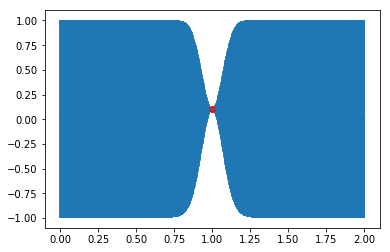

In [8]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(t_2, y_pred, yerr=sigmas, capsize=0)
plt.plot(t_1, y_1, 'ro')

In [9]:
t_1.append(1.3)
y_1.append(0.3)

predictions = [predict(i, t_1, kernel, theta, y_1) for i in t_2]

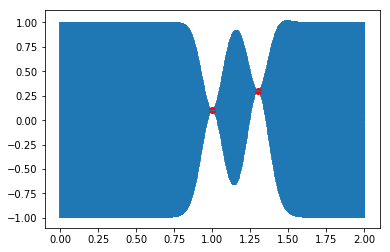

In [10]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(t_2, y_pred, yerr=sigmas, capsize=0)
plt.plot(t_1, y_1, 'ro')

In [39]:
t_1 = [0.1, 0.4, 1.7, 2.3, 2.9, 3.0]
y_1 = np.random.multivariate_normal(np.zeros(len(t_1)), kernel(t_1, t_1, [1.0, 1.0]))
t_2 = np.linspace(0, 4, 1000)
predictions = [predict(i, t_1, kernel, theta, y_1) for i in t_2]

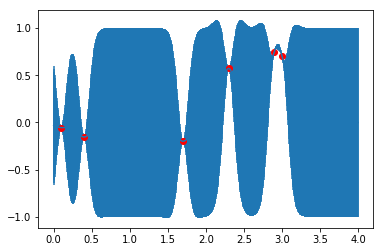

In [40]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(t_2, y_pred, yerr=sigmas, capsize=0)
plt.plot(t_1, y_1, 'ro')

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


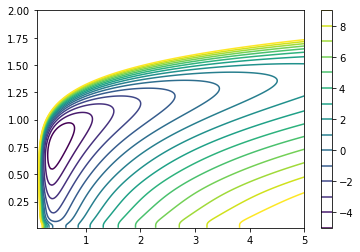

In [42]:
nps = 300
ls = np.linspace(0.01,2,nps)
sigmas = np.linspace(0.1,5.0,nps)
L = np.zeros([nps, nps])
for idx, l in enumerate(ls):
    for jdx, sigma in enumerate(sigmas):
        A = kernel(t_1, t_1, [sigma, l])
        L[idx, jdx] = like(y_1, A)
        
fig, ax = plt.subplots()
SIGMAS, LS = np.meshgrid(sigmas, ls)
levels = np.arange(-10, 10, 1)
CS = ax.contour(SIGMAS, LS, -1.0 * np.log(L), levels=levels)
cbar = fig.colorbar(CS)